In [1]:
# Загрузка данных
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import mode
from matplotlib import pyplot as plt 
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

train = pd.read_csv('C:/Users/n.andreianov/Desktop/Data Sience/ML Rosbank/train.csv')
test = pd.read_csv('C:/Users/n.andreianov/Desktop/Data Sience/ML Rosbank/test.csv')

# Загрузка данных для join'a multi_currency
train_with_multi_index = pd.read_csv('C:/Users/n.andreianov/Desktop/Data Sience/ML Rosbank/my_work/additional_data/train_with_multi_index.csv')
test_with_multi_index = pd.read_csv('C:/Users/n.andreianov/Desktop/Data Sience/ML Rosbank/my_work/additional_data/test_with_multi_index.csv')
multi_tr = train_with_multi_index.groupby('cl_id')[['multi_currency']].first()
multi_te = test_with_multi_index.groupby('cl_id')[['multi_currency']].first()

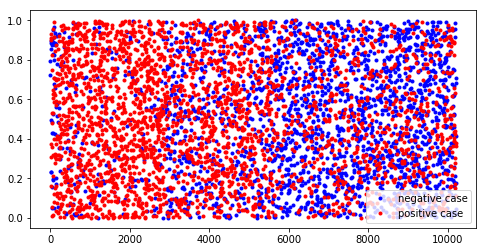

In [2]:
# График зависимости cl_id и target_flag
plt.figure(figsize=(8,4))
X = train[['cl_id','target_flag']].groupby('cl_id').agg('max').reset_index()
ind = X['target_flag']==0
plt.plot(X['cl_id'][ind], np.random.rand(np.sum(ind)), 'b.', label='negative case')
ind = X['target_flag']==1
plt.plot(X['cl_id'][ind], np.random.rand(np.sum(ind)), 'r.', label='positive case')
plt.legend()

In [3]:
# Добавляем фичу mode_MCC (count наиболее часто встречающихся MCC для каждого cl_id)
def add_mode_MCC(df):
    df['MCC'] = df['MCC'].astype('int')
    add_mode = df[['cl_id','MCC']].groupby('cl_id').apply(lambda x: mode(x)[1][0][1])
    add_mode = pd.DataFrame(add_mode).reset_index()
    add_mode.columns = ['cl_id','mode_MCC']
    df = pd.merge(df, add_mode, how='left', on='cl_id')
    return df

train = add_mode_MCC(train)
test = add_mode_MCC(test)

In [4]:
# Составляем словарь месяцев для парсинга
dt_dict = {
    'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'APR':'04',
    'MAY':'05', 
    'JUN':'06',  
    'JUL':'07',
    'AUG':'08',
    'SEP':'09',
    'OCT':'10',
    'NOV':'11', 
    'DEC':'12',   
}

# Парсинг поля TRDATETIME
def dt_preprocess_date(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]

    return '20'+str(year)+'-'+str(month)+'-'+str(day)

train['time'] = train['TRDATETIME'].apply(lambda x: dt_preprocess_date(x))
train['time'] = pd.to_datetime(train['time'])
test['time'] = test['TRDATETIME'].apply(lambda x: dt_preprocess_date(x))
test['time'] = pd.to_datetime(train['time'])

# Парсинг поля TRDATETIME (+hour/min/sec)
def dt_preprocess_time(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)+' '+str(hour)+":"+str(minute)+':'+str(second)

train['TRDATETIME'] = train['TRDATETIME'].apply(lambda x: dt_preprocess_time(x))
train['TRDATETIME'] = pd.to_datetime(train['TRDATETIME'])
test['TRDATETIME'] = test['TRDATETIME'].apply(lambda x: dt_preprocess_time(x))
test['TRDATETIME'] = pd.to_datetime(test['TRDATETIME'])

#train['month'] = train['TRDATETIME'].dt.month + (train['TRDATETIME'].dt.year-2016)*12
#test['month'] = test['TRDATETIME'].dt.month + (test['TRDATETIME'].dt.year-2016)*12

#train['days_since2015'] = (train['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days
#test['days_since2015'] = (test['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days

In [5]:
# Добавляем фичу num_days_in_use
def diff_months(x):
    a = np.max(x) - np.min(x)
    return a.days

def add_num_days_in_use(df):
    sum_deals = df[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_months).reset_index()
    sum_deals.columns = ['cl_id','num_days_in_use']
    df = pd.merge(df, sum_deals, how='left', on='cl_id')
    return df

train = add_num_days_in_use(train)
test = add_num_days_in_use(test)

In [6]:
# Загрузка кодов MCC
import requests
def simplify_MCC(df):
    mcc_codes_table = pd.read_html(requests.get('https://mcc-codes.ru/code', headers={'User-agent': 'Mozilla/5.0'}).text, converters={'MCC': str})[0]
    mcc_map = mcc_codes_table[['MCC', 'Группа']].set_index('MCC').to_dict()['Группа']
    df['MCC'] = df['MCC'].astype(str).map(mcc_map)
    return df

train = simplify_MCC(train)
test = simplify_MCC(test)
train.MCC = train.MCC.fillna('Различные магазины')
test.MCC = test.MCC.fillna('Различные магазины')

# Вместо пустого значений channel_type пишем type0
train.channel_type = train.channel_type.fillna('type0')
test.channel_type = test.channel_type.fillna('type0')

In [7]:
# Маппинг полей trx_category
def mapping_trx_category(df):
    trx_category_mapping = {"POS": 0, "C2C_OUT": 1, "WD_ATM_PARTNER": 2, "WD_ATM_ROS": 3, "WD_ATM_OTHER": 4, "CASH_ADV": 5, "C2C_IN": 6, "DEPOSIT": 7, "BACK_TRX": 8, "CAT": 9}
    df['trx_category'] = df['trx_category'].map(trx_category_mapping)
    return df

train = mapping_trx_category(train)
test = mapping_trx_category(test)

# Составляем однородные группы для trx_category
def simplify_trx_category(df):
    bins = (-0.5, 0.5, 5.5, 8.5, 10)
    group_names = ['POS', 'OUT', 'IN', 'CAT']
    categories = pd.cut(df.trx_category, bins, labels=group_names)
    df.trx_category = categories
    return df

train = simplify_trx_category(train)
test = simplify_trx_category(test)

In [8]:
# Вычисялем корректный amount на основе валютных котировок
def calculate_amount(df):
    # Загружаем справочник с котировками валют
    exchange = pd.read_csv('C:/Users/n.andreianov/Desktop/Data Sience/ML Rosbank/my_work/additional_data/exchange.csv')
    exchange = exchange.rename(index=str, columns={"ID": "currency"})

    # Добавляем столбец 'value' в датафрейм train
    df = df.set_index('currency')
    exchange = exchange.set_index('currency')
    df = df.join(exchange)

    # Сбрасываем индексы, сортируем по 'cl_id'
    df = df.reset_index()
    df = df.sort_values(by=['cl_id'])
    
    # Вычисляем корректный 'amount'
    df['amount'] = df.amount * df.value
    return df

train = calculate_amount(train)
test = calculate_amount(test)

# выбросы
train = train[train['amount'] > 10]

In [9]:
# Агрегируем фичи
def agg_data(df):
    
    agg = df.groupby('cl_id')[['channel_type']].first()
    ID = agg.index
    agg['cl_id'] = ID
    agg['PERIOD_count'] = df.groupby('cl_id')['PERIOD'].nunique()
    agg['sum_POS'] = df[df.trx_category == 'POS'].groupby('cl_id')['amount'].sum()
    agg['sum_IN'] = df[df.trx_category == 'IN'].groupby('cl_id')['amount'].sum()
    agg['sum_OUT'] = df[df.trx_category == 'OUT'].groupby('cl_id')['amount'].sum()
    agg['sum_CAT'] = df[df.trx_category == 'CAT'].groupby('cl_id')['amount'].sum()
    agg['sum_amount'] = df.groupby('cl_id')['amount'].sum()
    
    mcc_groups = df.MCC.unique()
    for MCC_g in mcc_groups:
        agg['sum_{}'.format(MCC_g)] = df[(df.MCC == MCC_g)].groupby('cl_id')['amount'].sum()
        
    return agg.fillna(0)

train_agg = agg_data(train)
test_agg = agg_data(test)


# join 'multi_currency'
train_agg = train_agg.join(multi_tr)
test_agg = test_agg.join(multi_te)

In [10]:
# join'им фичи в итоговую выборку
train_mode_MCC = train.groupby('cl_id')[['mode_MCC']].first()
test_mode_MCC = test.groupby('cl_id')[['mode_MCC']].first()
train_num_days_in_use = train.groupby('cl_id')[['num_days_in_use']].first()
test_num_days_in_use = test.groupby('cl_id')[['num_days_in_use']].first()
train_agg = train_agg.join(train_mode_MCC)
test_agg = test_agg.join(test_mode_MCC)
train_agg = train_agg.join(train_num_days_in_use)
test_agg = test_agg.join(test_num_days_in_use)

In [11]:
train_agg.head(6)

,channel_type,cl_id,PERIOD_count,sum_POS,sum_IN,sum_OUT,sum_CAT,sum_amount,sum_Розничные магазины,sum_Поставщик услуг,...,sum_Ремонтные услуги,sum_Аренда автомобилей,sum_Продажи по почте/телефону,sum_Оптовые поставщики и производители,"sum_Авиалинии, авиакомпании",sum_Членские организации,sum_Контрактные услуги,multi_currency,mode_MCC,num_days_in_use
cl_id,,,,,,,,,,,,,,,,,,,,,
0,type0,0,2,7821.000000,20000.0,36562.00,0.00,6.438300e+04,7054.000000,56562.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,rub,1,53
1,type0,1,4,187052.671091,95000.0,50000.00,0.00,3.320527e+05,23103.940122,145886.3212,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,multi + rub,41,92
5,type0,5,4,302374.362892,143990.0,111878.38,0.00,5.582427e+05,63968.355072,241878.3800,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,multi + rub,31,92
9,type0,9,3,12365.090000,301950.0,535000.00,0.00,8.493151e+05,39.000000,836950.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,rub,27,89
10,type0,10,3,200798.210000,436300.0,449392.90,37694.98,1.124186e+06,119800.310000,923387.8800,...,650.0,0.0000,0.0,0.0,0.0,0.0,0.0,rub,103,89
11,type0,11,4,251884.517829,182000.0,0.00,0.00,4.338845e+05,35778.847910,182000.0000,...,783.0,443.1606,0.0,0.0,0.0,0.0,0.0,multi + rub,63,91


In [12]:
# Убираем выбросы
train = train.drop_duplicates('cl_id')
train = train.set_index('cl_id')
train_agg['target_flag']=train['target_flag']
train_agg['target_sum']=train['target_sum']

train_agg = train_agg[train_agg.PERIOD_count != 8]
train_agg = train_agg[train_agg.PERIOD_count != 10]
train_agg = train_agg[train_agg.PERIOD_count != 11]
train_agg = train_agg[train_agg.PERIOD_count != 6]
train_agg = train_agg[train_agg.PERIOD_count != 7]
train_agg = train_agg[train_agg.PERIOD_count != 9]
train_agg = train_agg[train_agg.PERIOD_count != 14]

# Находим остаток на карте
train_agg['ostatok'] = train_agg.sum_IN - (train_agg.sum_POS + train_agg.sum_OUT)
test_agg['ostatok'] = test_agg.sum_IN - (test_agg.sum_POS + test_agg.sum_OUT)

In [13]:
train_agg.to_csv("tr.csv")

In [14]:
# Кодируем данные типа "category", на выходе получаем датафрейм, в котором все значения типа int и float
from sklearn import preprocessing
def encode_features(tr, te):
    features = ['channel_type', 'multi_currency']
    df_combined = pd.concat([tr[features], te[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature].astype(str))
        tr[feature] = le.transform(tr[feature].astype(str))
        te[feature] = le.transform(te[feature].astype(str))
    return tr, te
    
train_agg, test_agg = encode_features(train_agg, test_agg)

predictors = test_agg.columns
X_train = train_agg[predictors].values
X_test = test_agg[predictors].values

y_train_1 = train_agg.groupby('cl_id')['target_flag'].first()
y_train_2 = np.log(train_agg.groupby('cl_id')['target_sum'].first() + 1.0)

C:\Users\n.andreianov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: 'cl_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
C:\Users\n.andreianov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: 'cl_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


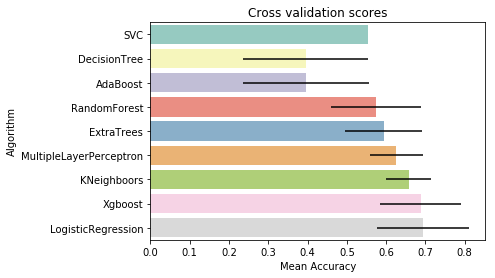

In [15]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures

# Используем модель pipeline
pipe1 = make_pipeline(StandardScaler(),
                      SelectFromModel(estimator=RandomForestClassifier()),
                      LogisticRegression())

z = cross_val_score(pipe1, X_train, y_train_1, scoring='roc_auc', n_jobs=4).mean()
#while z < 0.875:
#    z = cross_val_score(pipe1, X_train, y_train_1, scoring='roc_auc', n_jobs=4).mean()
print('LR + selection: ', z)

#LR + selection:  0.8729700713198151

LR + selection:  0.8707327555206033


In [16]:
# Обучаем модель на train выборке и делаем предикты на X_test и X_train
pipe1.fit(X_train, y_train_1)
pred = pipe1.predict_proba(X_test)[:, 1]
submission = test_agg.copy()[['cl_id']]
submission['pred'] = (pred - pred.min()) / (pred.max() - pred.min())

pred1 = pipe1.predict_proba(X_train)[:, 1]
submission1 = train_agg.copy()[['cl_id']]
submission1['pred'] = (pred1 - pred1.min()) / (pred1.max() - pred1.min())

a1 = np.array(submission1['pred'])[np.newaxis]
b1 = np.array(submission['pred'])[np.newaxis]

a1 = np.concatenate((X_train, a1.transpose()), axis = 1)
b1 = np.concatenate((X_test, b1.transpose()), axis = 1)

In [22]:
# Если хотим использовать полученный результат модели Pipe1, то везде вместо X_train пишем a1
# Считаем скоры
kf_1 = list(KFold(4, shuffle = True, random_state = 0).split(a1, y_train_1))
kf_2 = list(KFold(4, shuffle = True, random_state = 0).split(a1, y_train_2))

xgb1 = XGBClassifier()
xgb2 = XGBRegressor()

result_1 = np.mean(cross_val_score(xgb1, a1, y_train_1, scoring = 'roc_auc', cv = kf_1, n_jobs = 1))
result_2 = np.mean(cross_val_score(xgb2, a1, y_train_2, scoring = 'neg_mean_squared_error', cv = kf_2, n_jobs = 1))

print('Score_1task: {0:.4}'.format(result_1))
print('Score_2task: {0:.4}'.format((-result_2) ** 0.5))

#Score_1task: 0.8529
#Score_2task: 4.115

Score_1task: 0.8537
Score_2task: 4.12


In [32]:
# Обучаем модель на train выборке и делаем предикт на test
# Если хотим использовать полученный результат модели Pipe1, то везде вместо X_train пишем a1, а вместо X_test, b1

xgb1.fit(a1, y_train_1)
xgb2.fit(a1, y_train_2)
pred_1 = xgb1.predict_proba(b1)[:, 1]
pred_2 = np.exp(xgb2.predict(b1)) - 1
pred_2[pred_2 <= 0] = 0

In [33]:
# Cоздаем выходной датафрейм с предиктами
submission_1 = test_agg.copy()[['cl_id']]
submission_1['pred_1'] = (pred_1 - pred_1.min()) / (pred_1.max() - pred_1.min())
submission_2 = test_agg.copy()[['cl_id']]
submission_2['pred_2'] = pred_2 

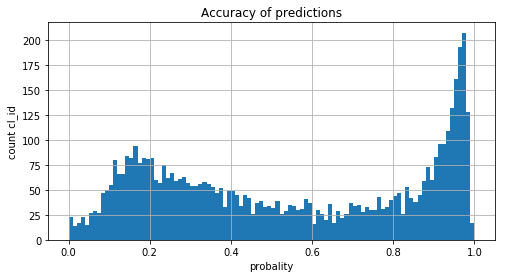

In [34]:
# График зависомости предикшена target_flag от cl_id
plt.figure(figsize=(8,4))
plt.hist(submission_1['pred_1'].values, bins = 100)
plt.title('Accuracy of predictions')
plt.xlabel('probality')
plt.ylabel('count cl_id')
plt.grid()
plt.show()

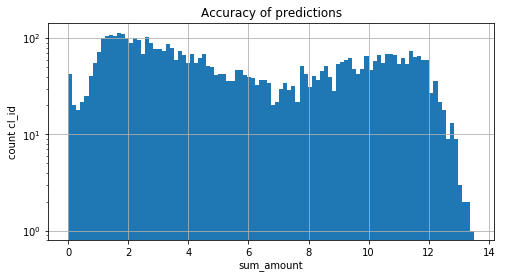

In [35]:
# График зависомости предикшена sum_amount от cl_id
plt.figure(figsize=(8,4))
plt.hist(np.log(1 + submission_2['pred_2'].values), bins = 100, log = True)
plt.title('Accuracy of predictions')
plt.xlabel('sum_amount')
plt.ylabel('count cl_id')
plt.grid()
plt.show()

In [198]:
submission_1.to_csv('result_1.csv', index = False)
submission_2.to_csv('result_2.csv', index = False)